### downloading data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")

print("Path to dataset files:", path)

100%|██████████| 283M/283M [00:01<00:00, 204MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/badasstechie/celebahq-resized-256x256/versions/1


In [2]:
import os
import shutil
from pathlib import Path

# Define source and destination directories
source_dir = Path("/root/.cache/kagglehub/datasets/badasstechie/celebahq-resized-256x256/versions/1/celeba_hq_256" )
train_dir = Path("images/train")
valid_dir = Path("images/valid")

# Create destination directories
train_dir.mkdir(parents=True, exist_ok=True)
valid_dir.mkdir(parents=True, exist_ok=True)

# Get list of image files
image_files = list(source_dir.glob("*.jpg"))

# Define split ratio (e.g., 80% train, 20% valid)
split_ratio = 0.8
split_index = int(len(image_files) * split_ratio)

# Split files
train_files = image_files[:split_index]
valid_files = image_files[split_index:]

# Move files to respective directories
print("Moving training images...")
for file in train_files:
    shutil.move(str(file), str(train_dir / file.name))

print("Moving validation images...")
for file in valid_files:
    shutil.move(str(file), str(valid_dir / file.name))

print("Image splitting complete.")

Moving training images...
Moving validation images...
Image splitting complete.


In [3]:
import glob
len(list(glob.glob("images/valid/*")))

6000

In [4]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 4.9 MB/s eta 0:00:00


In [5]:
import os
from pathlib import Path
from PIL import Image
import random

import torch
from torch import nn
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import torchvision.transforms as tf
from torch.utils.data import DataLoader

from piq import ssim
import matplotlib.pyplot as plt
import tqdm

In [6]:
class UFaceDataset(Dataset):
    def __init__(self, path, transform):
        super().__init__()
        self.paths = [p for p in Path(path).rglob("*.jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        try:
            img = Image.open(self.paths[index])
            main = self.transform(img)

            kernel_size = random.choice([5, 7, 9])
            sigma = random.uniform(0.4, 6.0)
            blured = F.gaussian_blur(main, kernel_size=kernel_size, sigma=sigma)

            noise = torch.randn_like(blured) * 0.1
            noisy_blured = torch.clamp(blured + noise, 0.0, 1.0)

            return {
                'main': main,
                'blured': blured,
                'noisy': noisy_blured
            }

        except Exception as e:
            print(f"error while opening image at index {index}, path: {self.paths[index]}")
            raise e

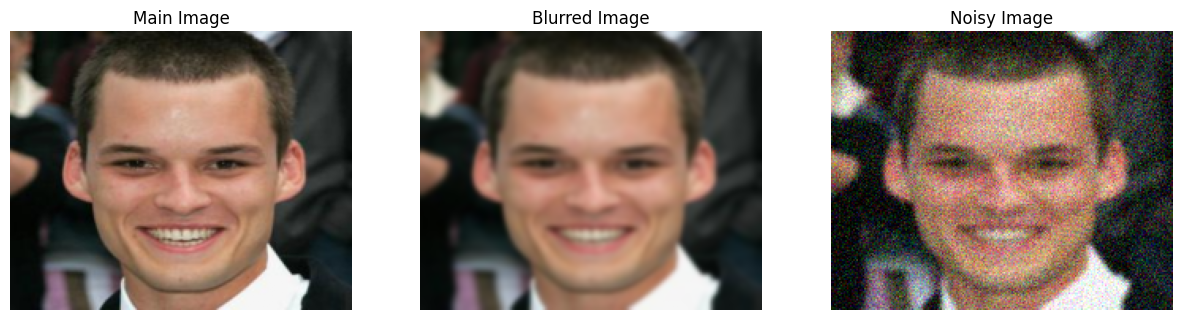

In [7]:
if __name__ == "__main__":
    transform = tf.Compose([
        tf.Resize([176, 216]),
        tf.ToTensor(),
    ])
    ds = UFaceDataset("images/train", transform)
    sample = ds[12]

    main_img = sample['main'].permute(1, 2, 0).numpy()
    blured_img = sample['blured'].permute(1, 2, 0).numpy()
    noisy_img = sample['noisy'].permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(main_img)
    axes[0].set_title("Main Image")
    axes[0].axis('off')

    axes[1].imshow(blured_img)
    axes[1].set_title("Blurred Image")
    axes[1].axis('off')

    axes[2].imshow(noisy_img)
    axes[2].set_title("Noisy Image")
    axes[2].axis('off')

    plt.show()


In [22]:
class UFaceDataset(Dataset):
    def __init__(self, path, transform):
        super().__init__()
        self.paths = [p for p in Path(path).rglob("*.jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        try:
            img = Image.open(self.paths[index])
            main = self.transform(img)

            kernel_size = random.choice([5, 7, 9])
            sigma = random.uniform(0.4, 6.0)
            blured = F.gaussian_blur(main, kernel_size=kernel_size, sigma=sigma)

            # Make noise level random
            noise_level = random.uniform(0.05, 0.1)
            noise = torch.randn_like(blured) * noise_level
            noisy_blured = torch.clamp(blured + noise, 0.0, 1.0)

            return {
                'main': main,
                'noisy': noisy_blured
            }

        except Exception as e:
            print(f"error while opening image at index {index}, path: {self.paths[index]}")
            raise e

In [9]:
class FaceUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # feature size / 2
        # channel 3 -> 64
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # /2
        )

        # feature size * 2
        # channel 64 -> 3
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        # after concatenating output of up 3 with the input image
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, padding=1, stride=1)  # 3 channels

        # ===============================================================================================

        # feature size / 2
        # channel 64 -> 128
        self.down2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),  # [128]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # /2
        )

        # feature size * 2
        # channel 128 -> 64
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        # after concatenating output of up 2 with output of down 1
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1)  # 64 channels

        # ===============================================================================================

        # feature size / 2
        # channel 128 -> 256
        self.down3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),  # [256]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # /2
        )

        # feature size * 2
        # channel 256 -> 128
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # *2 , [64]
            nn.ReLU(),
        )

        # after concatenating output of up 1 with output of down 2
        self.conv3 = nn.Conv2d(256, 128,  kernel_size=3, padding=1, stride=1)  # 128 channels

        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        identity0 = x  # c = 3

        # ==--==--==--==-
        x = self.down1(x)  # c = 64
        identity1 = x  # c = 64

        # ==--==--==--==-
        x = self.down2(x)  # c = 128
        identity2 = x  # c = 128

        # ==--==--==--==-
        x = self.down3(x)  # c = 256

        # ==--==--==--==-
        x = self.up3(x)  # c = 128
        x = torch.cat([x, identity2], dim=1)  # c = 256
        x = self.conv3(x)  # c = 128  |  recover the channels again

        # ==--==--==--==-
        x = self.up2(x)  # c = 64
        x = torch.cat([x, identity1], dim=1)  # c = 128
        x = self.conv2(x)  # c = 64  |  recover the channels again

        # ==--==--==--==-
        x = self.up1(x)
        x = torch.cat([x, identity0], dim=1)  # c = 6
        x = self.sigmoid(self.conv1(x))  # c = 3  |  recover the channels again

        return x

In [10]:
class FaceUNetLoss(nn.Module):
    def __init__(self, lambda_ssim: float = 0.3):
        super().__init__()
        self.lambda_ssim = lambda_ssim
        self.mse_loss = nn.MSELoss()

    def forward(self, pred, target):
        mse_part = self.mse_loss(pred, target)
        ssim_part = 1 - ssim(pred, target)
        return mse_part + self.lambda_ssim * ssim_part

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"starting operation on device: {DEVICE}")

starting operation on device: cuda


In [12]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
# paths
train_path = "images/train"
valid_path = "images/valid"

# transforms
transform = tf.Compose([
    tf.Resize([176, 216]),
    tf.ToTensor(),
])

In [23]:
train_dataset = UFaceDataset(train_path, transform)
valid_dataset = UFaceDataset(valid_path, transform)

print(f"found {len(train_dataset)} training images")
print(f"found {len(valid_dataset)} validation images")

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

found 24000 training images
found 6000 validation images


In [16]:
model = FaceUNet().to(DEVICE)
criterion = FaceUNetLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
epochs = 10

# early stopping
patience_number = 2
delta = 0.001
best_val_loss = float("inf")
patience = 0

# outputs
os.makedirs("outputs", exist_ok=True)
os.makedirs("outputs/checkpoints", exist_ok=True)
train_losses = []
val_losses = []

In [24]:
print(f"🚀 Start training with {epochs} epochs ...")

for epoch in range(epochs):
    # train
    model.train()
    train_loss = 0.0

    for batch in tqdm.tqdm(train_loader, total=len(train_loader), desc="training  "):
        blrd_img, main_img = batch["noisy"].to(DEVICE), batch["main"].to(DEVICE)

        optimizer.zero_grad()
        output = model(blrd_img)
        loss = criterion(output, main_img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in tqdm.tqdm(valid_loader, total=len(valid_loader), desc="validating"):
            blrd_img, main_img = batch["noisy"].to(DEVICE), batch["main"].to(DEVICE)

            output = model(blrd_img)
            loss = criterion(output, main_img)
            valid_loss += loss.item()

    avg_val_loss = valid_loss / len(valid_loader)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}", end=" | ")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # early stopping
    if avg_val_loss < best_val_loss - delta:
        best_val_loss = avg_val_loss
        patience = 0
        torch.save(model.state_dict(), "outputs/checkpoints/superres_best.pth")
        print(f"✅ Validation improved. Saving model.\n")
    else:
        patience += 1
        print(f"⚠️ No improvement. Early stop counter: {patience}/{patience_number}")
        if patience >= patience_number:
            print("⛔ Early stopping triggered!\n")
            break

🚀 Start training with 10 epochs ...


validating: 100%|██████████| 24/24 [00:43<00:00,  1.80s/it]


[Epoch 1] Train Loss: 0.0481 | Val Loss: 0.0476 | ✅ Validation improved. Saving model.



validating: 100%|██████████| 24/24 [00:43<00:00,  1.81s/it]


[Epoch 2] Train Loss: 0.0470 | Val Loss: 0.0464 | ✅ Validation improved. Saving model.



validating: 100%|██████████| 24/24 [00:42<00:00,  1.79s/it]


[Epoch 3] Train Loss: 0.0463 | Val Loss: 0.0457 | ⚠️ No improvement. Early stop counter: 1/2


validating: 100%|██████████| 24/24 [00:43<00:00,  1.79s/it]


[Epoch 4] Train Loss: 0.0458 | Val Loss: 0.0452 | ✅ Validation improved. Saving model.



validating: 100%|██████████| 24/24 [00:43<00:00,  1.80s/it]


[Epoch 5] Train Loss: 0.0454 | Val Loss: 0.0452 | ⚠️ No improvement. Early stop counter: 1/2


validating: 100%|██████████| 24/24 [00:43<00:00,  1.80s/it]

[Epoch 6] Train Loss: 0.0451 | Val Loss: 0.0450 | ⚠️ No improvement. Early stop counter: 2/2
⛔ Early stopping triggered!



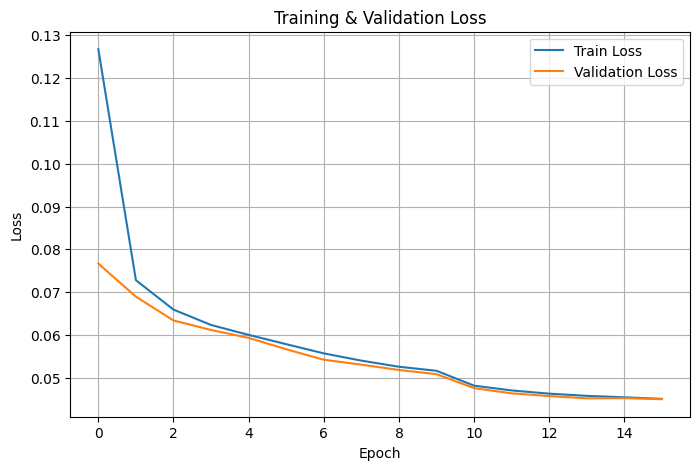

In [25]:
plot_losses(train_losses, val_losses)

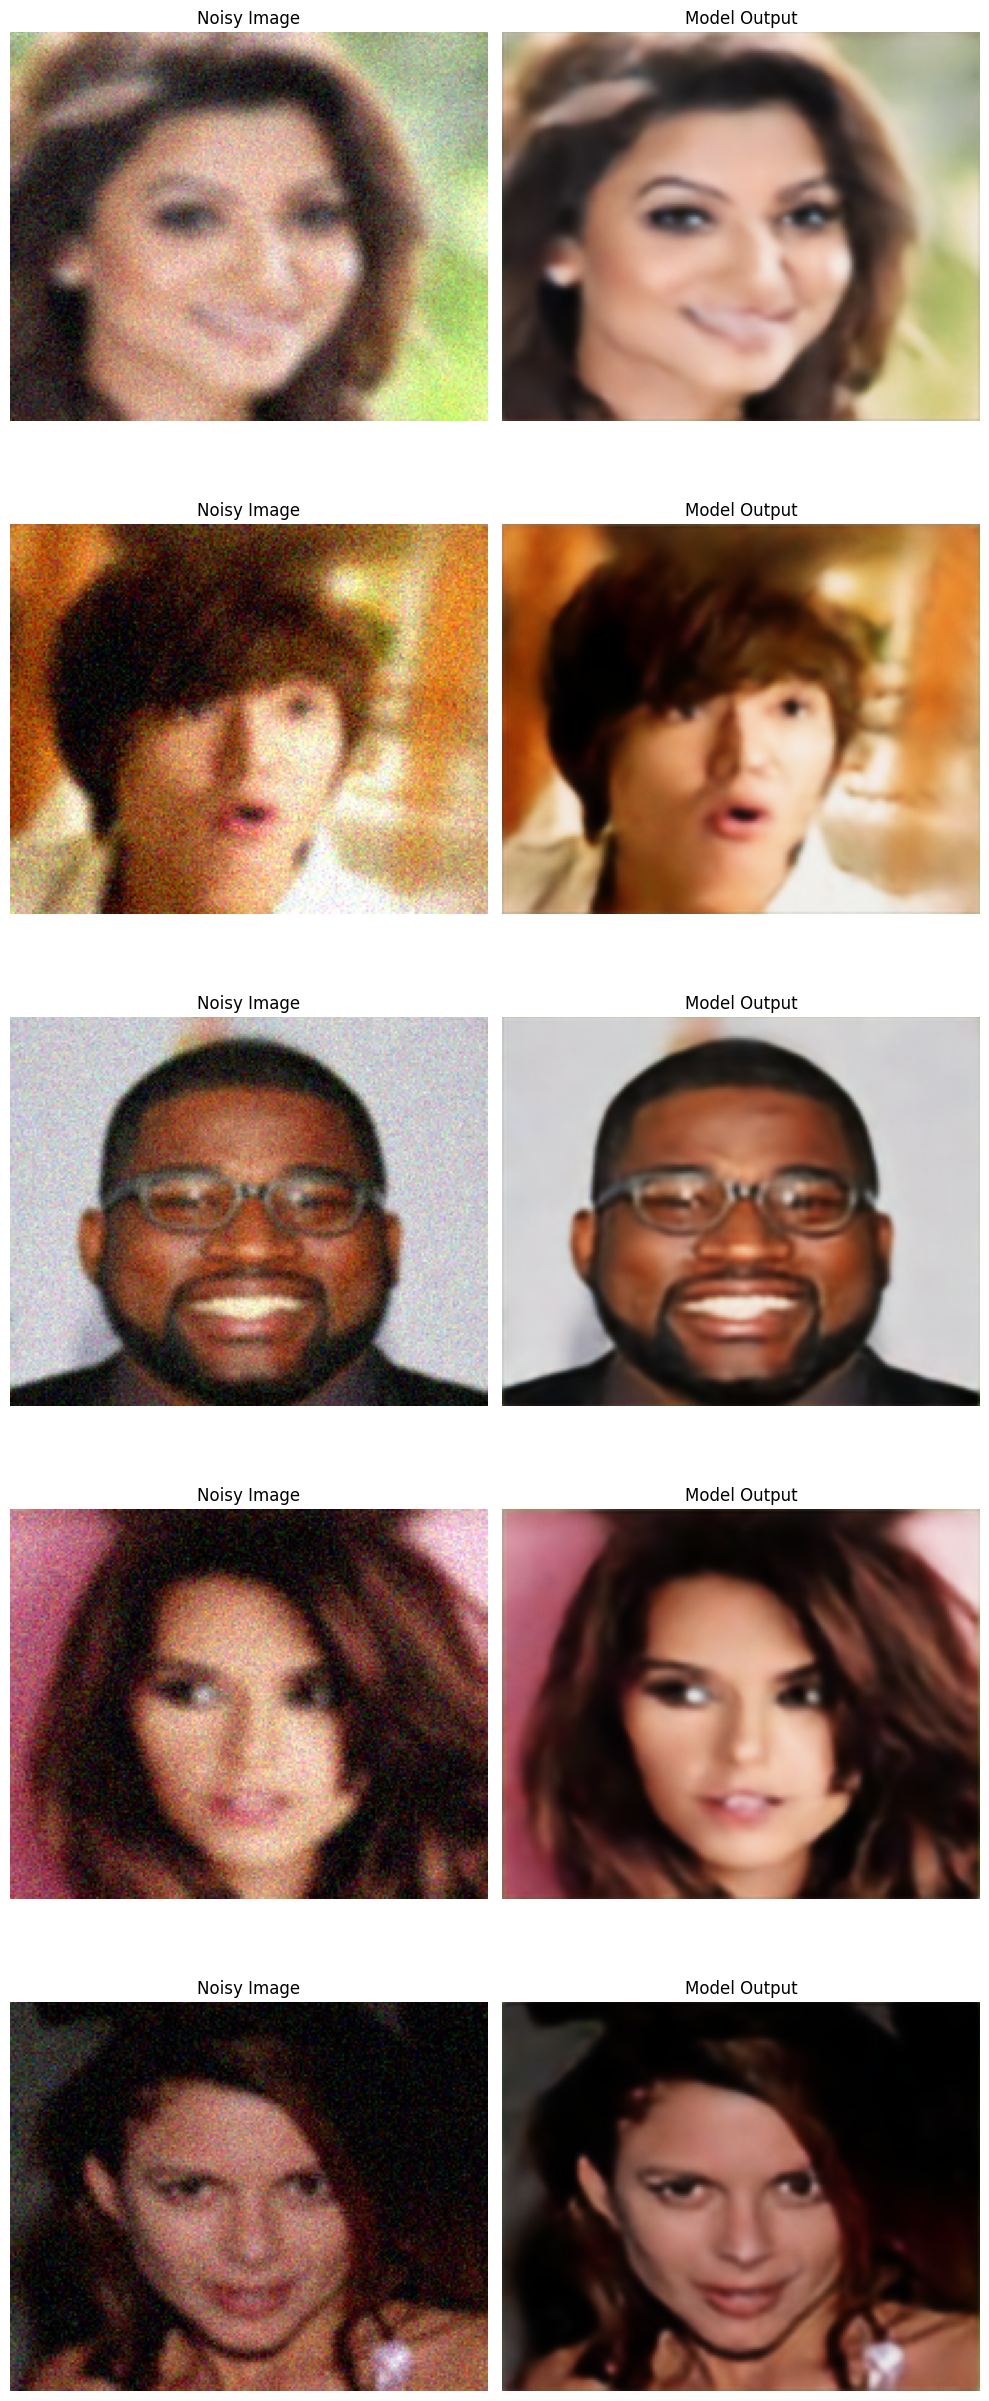

In [26]:
# Select a few random indices from the validation dataset
num_samples = 5
random_indices = random.sample(range(len(valid_dataset)), num_samples)

# Get samples from the dataset and move to device
samples = [valid_dataset[i] for i in random_indices]
noisy_images = torch.stack([s['noisy'] for s in samples]).to(DEVICE)

# Get model output
model.eval()
with torch.no_grad():
    outputs = model(noisy_images)

# Plot the original noisy images and the model outputs
fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

for i in range(num_samples):
    noisy_img = noisy_images[i].cpu().permute(1, 2, 0).numpy()
    output_img = outputs[i].cpu().permute(1, 2, 0).numpy()

    axes[i, 0].imshow(noisy_img)
    axes[i, 0].set_title("Noisy Image")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(output_img)
    axes[i, 1].set_title("Model Output")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()